In [1]:
# %matplotlib agg
%run utils.ipynb

In [2]:
import matplotlib.pyplot as plt
from matplotlib import colors, ticker
import pandas as pd
import numpy as np
import scipy as sp
from astropy.table import Table
import astropy.units as u
import astropy.coordinates as coord
import arviz as az
import seaborn as sns

import kinesis as kn
import gapipes as gp

# This does not work with 'inline' backend: it will output latex
# compile error although PDF outputs etc will be saved correctly.
# I do not know why.
mystyledict.update({"text.usetex": True, "axes.unicode_minus": True})
plt.style.use(mystyledict)

In [3]:
def savefig(fig, basename, **kwargs):
    fig.savefig("../report/plots/plot-comparisons/{}.pdf".format(basename), **kwargs)

In [6]:
out_full = pd.read_csv("../data/hyades_full.csv")
df = out_full.loc[out_full["in_dr2"] == True].copy()
b0 = np.median(df.g.icrs.cartesian.xyz.value, axis=1)
with np.printoptions(formatter=dict(float=lambda x: "{:7.3f}".format(x))):
    print(f"b0 = {b0} pc")


def add_cartesian_xv(df):
    df["x"], df["y"], df["z"] = df.g.icrs.cartesian.xyz.value
    df["vx"], df["vy"], df["vz"] = df.g.icrs.velocity.d_xyz.value
    df["gx"], df["gy"], df["gz"] = df.g.galactic.cartesian.xyz.value
    df["gvx"], df["gvy"], df["gvz"] = df.g.galactic.velocity.d_xyz.value


add_cartesian_xv(out_full)
add_cartesian_xv(df)

fit_dict = {
    "dr2": kn.load_stanfit("../report/hyades-dr2/fit.pickle"),
    "corrected": kn.load_stanfit("../report/hyades-dr2/fit_brightcorr.pickle"),
    "all": kn.load_stanfit("../report/hyades-dr2/fit_allstars.pickle"),
#     'haprs':kn.load_stanfit("../report/hyades-dr2/fit_harpsrv.pickle"),
    "all corrected": kn.load_stanfit("../report/hyades-dr2/fit_allstars_brightcorr.pickle")
}
azfit_dict = {
    k: add_transformed_posterior(az.from_pystan(v)) for k, v in fit_dict.items()
}

b0 = [ 17.268  41.643  13.606] pc


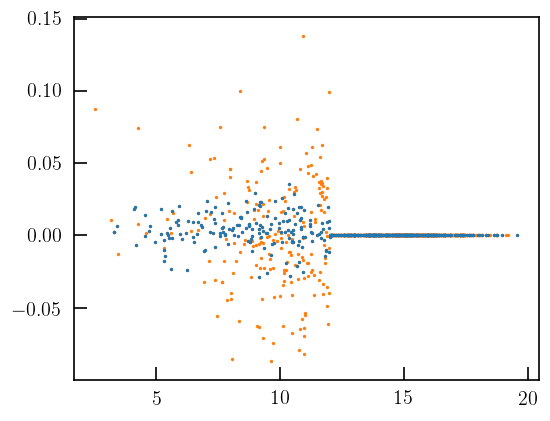

In [26]:
plt.scatter(out_full['phot_g_mean_mag'],
            fit_dict['all'].data['a'][:,1]-fit_dict['all corrected'].data['a'][:,1],s=1,c='C1');
plt.scatter(df['phot_g_mean_mag'],
            fit_dict['dr2'].data['a'][:,1]-fit_dict['corrected'].data['a'][:,1],s=1,c='C0');

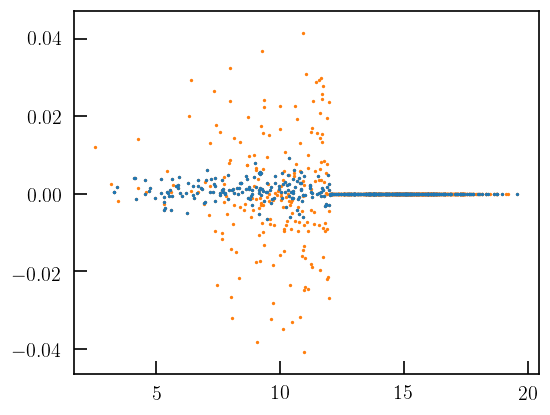

In [12]:
plt.scatter(
    out_full["phot_g_mean_mag"],
    (fit_dict["all"].data["a"][:, 1] - fit_dict["all corrected"].data["a"][:, 1])
    / fit_dict["all"].data["a"][:, 0]
    * 4.74,
    s=1,
    c="C1",
)
plt.scatter(
    df["phot_g_mean_mag"],
    (fit_dict["dr2"].data["a"][:, 1] - fit_dict["corrected"].data["a"][:, 1])
    / fit_dict["dr2"].data["a"][:, 0]
    * 4.74,
    s=1,
    c="C0",
);

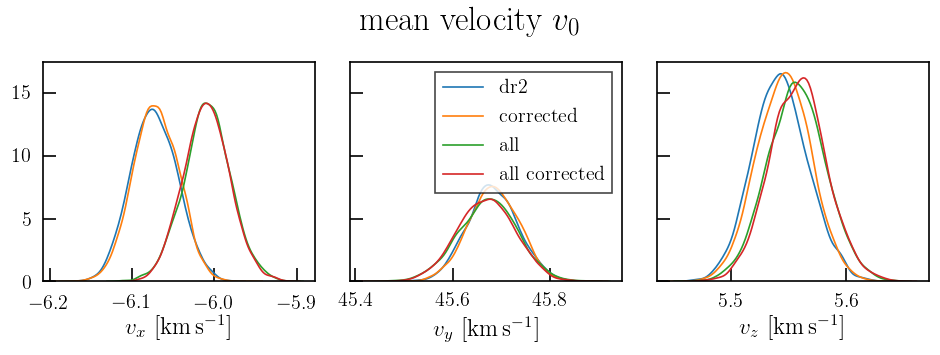

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(8, 3), sharey=True)

for i, cax in enumerate(ax):
    for k, v in azfit_dict.items():
        sns.kdeplot(
            v.posterior["v0"].stack(samples=["chain", "draw"])[i],
            ax=cax,
            legend=False,
            label=k,
        )
ax[0].set_xlabel("$v_x$ [$\mathrm{km}\,\mathrm{s}^{-1}$]")
ax[1].set_xlabel("$v_y$ [$\mathrm{km}\,\mathrm{s}^{-1}$]")
ax[2].set_xlabel("$v_z$ [$\mathrm{km}\,\mathrm{s}^{-1}$]")
fig.suptitle("mean velocity $v_0$", size=20)
ax[1].legend()
fig.tight_layout(rect=[0, 0, 1, 0.9])
# savefig(fig, "mean_velocity")

In [162]:
coord.ICRS(*(b0 * u.pc), representation_type="cartesian").transform_to(
    coord.Galactic
).cartesian

<CartesianRepresentation (x, y, z) in pc
    (-43.9034441, 0.17206561, -17.02724708)>

In [368]:
plt.rc("xtick", labelsize=12)

In [184]:
# to normalize dv/dx
(1 * u.km / u.s / u.pc).to(u.pc / (10 * u.Myr) / u.pc)

<Quantity 10.22712165 0.1 / Myr>

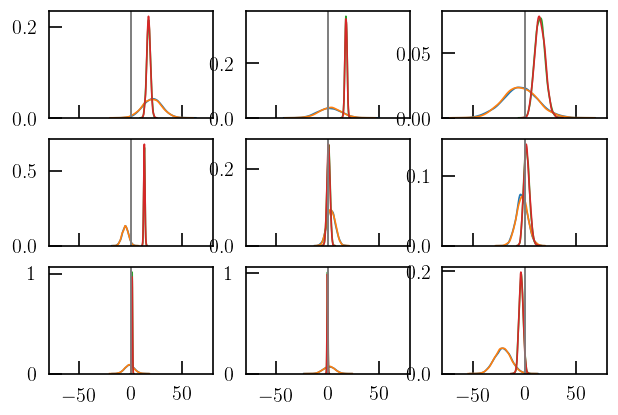

In [8]:
fig, ax = plt.subplots(3, 3, figsize=(6, 4), sharex=True, sharey=False, dpi=120)

for (k, stanfit), color in zip(fit_dict.items(), ["C0", "C1", "C3", "C4"]):
    for i in range(3):
        for j in range(3):
            T_galactic = kn.rotate_T_to_galactic(stanfit["T_param"])
#             T_sym = T_galactic + np.transpose(T_galactic, (0, 2, 1))
            sns.kdeplot(T_galactic[:, i, j], ax=ax[i, j])
            ax[i, j].axvline(0, c="0.5", lw=1)
ax[0, 0].set_xlim(-80, 80);

In [10]:
stanfit['Omega'].shape

(4000, 3, 3)

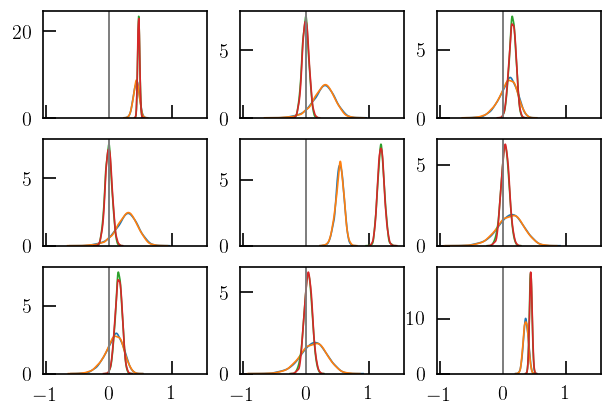

In [9]:
fig, ax = plt.subplots(3, 3, figsize=(6, 4), sharex=True, sharey=False, dpi=120)

for (k, stanfit), color in zip(fit_dict.items(), ["C0", "C1", "C3", "C4"]):
    for i in range(3):
        for j in range(3):
            if i==j:
                sns.kdeplot(stanfit['sigv'][:,i],ax=ax[i,j])
            else:
                sns.kdeplot(stanfit['Omega'][:,i,j], ax=ax[i,j])
            ax[i, j].axvline(0, c="0.5", lw=1)
# ax[0, 0].set_xlim(-80, 80);

## Membership

In [27]:
# add mean probmem to data
out_full['mean_pmem_all'] = fit_dict['all corrected']['probmem'].mean(axis=0)
df['mean_pmem_dr2'] = fit_dict['corrected']['probmem'].mean(axis=0)

In [28]:
print('mean fmem =', fit_dict['dr2']['f_mem'].mean(), fit_dict['all']['f_mem'].mean())

print('N(mean Pmem < 0.5) = ',
      (df['mean_pmem_dr2']<0.5).sum(), (out_full['mean_pmem_all']<0.5).sum())

mean fmem = 0.9956311769011815 0.8500334749188017
N(mean Pmem < 0.5) =  1 200


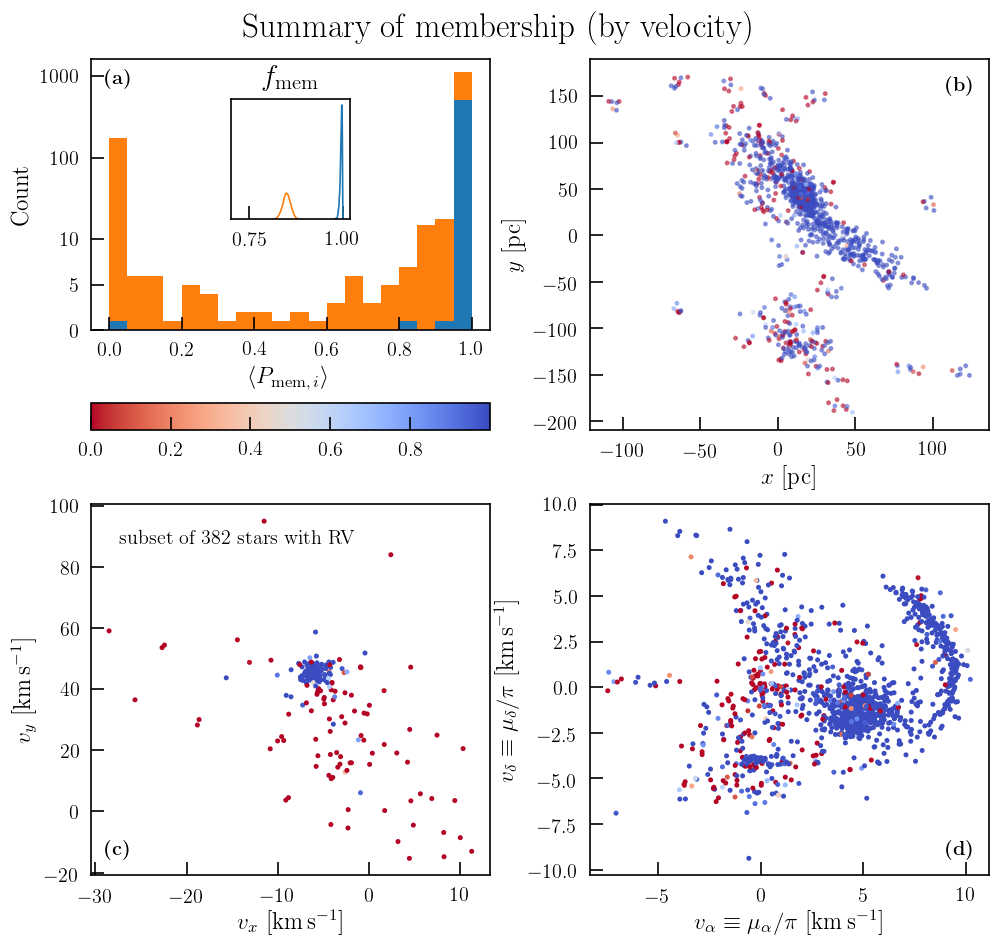

In [146]:
# Figure: summarize membership
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

fig, ax = plt.subplots(
    2,
    2,
    figsize=(8.5, 8),
    gridspec_kw=dict(top=0.93, right=0.98, left=0.1, bottom=0.08, wspace=0.25),
)
fig.suptitle("Summary of membership (by velocity)", size=20)

# histogram of mean Pmem
bins = np.linspace(0, 1, 21)
ax[0, 0].hist(df["mean_pmem_dr2"], bins=bins)
ax[0, 0].hist(out_full["mean_pmem_all"], bins=bins, color="C1", zorder=-1)
ax[0, 0].set_yscale("symlog", linthreshy=10)
ax[0, 0].set_yticks([0, 5, 10, 100, 1000])
ax[0, 0].set_yticklabels([0, 5, 10, 100, 1000])
axins = inset_axes(
    ax[0, 0],
    width="30%",  # width = 30% of parent_bbox
    height=1.0,  # height : 1 inch
    loc=9,
    borderpad=2,
)
axins.set_title("$f_\mathrm{mem}$")
for k, f in fit_dict.items():
    if k in ["dr2", "all"]:
        sns.kdeplot(f["f_mem"], ax=axins)
axins.set_xlim(0.7, 1.02)
axins.set_yticks([])
ax[0, 0].set_xlabel(r"$\langle P_{\mathrm{mem},\,i}\rangle$")
ax[0, 0].set_ylabel("Count")

# ICRS x-y space
# hacking colorbar
paths = ax[0, 1].scatter(
    out_full["x"],
    out_full["y"],
    c=out_full["mean_pmem_all"],
    s=4,
    cmap="coolwarm_r",
    visible=False,
)
_ = ax[0, 1].scatter(
    out_full["x"],
    out_full["y"],
    c=out_full["mean_pmem_all"],
    s=4,
    cmap="coolwarm_r",
    alpha=0.5,
)
# Attach colorbar below histogram for better arrangement
ax1_divider = make_axes_locatable(ax[0, 0])
cax1 = ax1_divider.append_axes("bottom", size="10%", pad="27%")
cb = plt.colorbar(paths, cax=cax1, orientation="horizontal")

ax[0, 1].set_xlabel("$x$ [pc]")
ax[0, 1].set_ylabel("$y$ [pc]")


ax[1, 0].scatter(
    out_full["vx"], out_full["vy"], c=out_full["mean_pmem_all"], s=4, cmap="coolwarm_r"
)
ax[1, 0].set_xlabel("$v_x$ [$\mathrm{km}\,\mathrm{s}^{-1}$]")
ax[1, 0].set_ylabel("$v_y$ [$\mathrm{km}\,\mathrm{s}^{-1}$]")
ax[1, 0].text(
    0.07,
    0.93,
    "subset of {} stars with RV".format(out_full["radial_velocity"].notnull().sum()),
    transform=ax[1, 0].transAxes,
    ha="left",
    va="top",
)

ax[1, 1].scatter(
    #     out_full["parallax"],
    #     out_full["vy"],
    out_full["pmra"] / out_full["parallax"],
    out_full["pmdec"] / out_full["parallax"],
    c=out_full["mean_pmem_all"],
    s=4,
    cmap="coolwarm_r",
)
# ax[1, 1].set_ylim(30, 65)
ax[1, 1].set_xlabel(r"$v_\alpha\equiv\mu_\alpha/\pi$ [$\mathrm{km}\,\mathrm{s}^{-1}$]")
ax[1, 1].set_ylabel(r"$v_\delta\equiv\mu_\delta/\pi$ [$\mathrm{km}\,\mathrm{s}^{-1}$]")

# label panels
for cax, (x, y, t) in zip(
    ax.ravel(),
    [
        (0.07, 0.93, r"\bf(a)"),
        (0.93, 0.93, r"\bf(b)"),
        (0.07, 0.07, r"\bf(c)"),
        (0.93, 0.07, r"\bf(d)"),
    ],
):
    cax.text(x, y, t, transform=cax.transAxes, va="center", ha="center")
savefig(fig, "membership", rasterized=True)

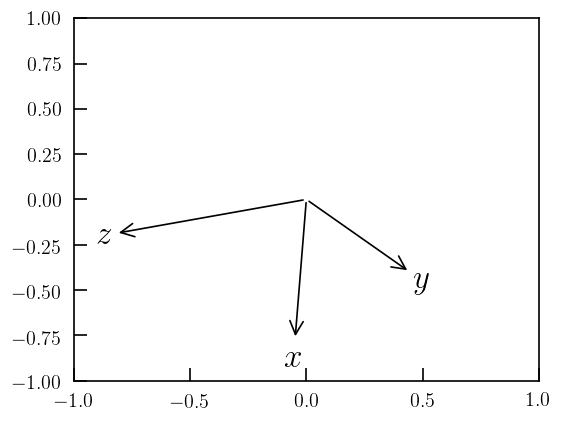

In [152]:
# annotate Galactic frame projected onto ICRS
unitv_gal_in_icrs = coord.Galactic(
    [1, 0, 0], [0, 1, 0], [0, 0, 1], representation_type="cartesian"
).transform_to(coord.ICRS).cartesian

xaxis, yaxis = 'x','y'
for i,axis in enumerate(['x','y','z']):
#     plt.plot([0,unitv_gal_in_icrs[i].x],[0,unitv_gal_in_icrs[i].y],label=axis,)
    dxdy = [getattr(unitv_gal_in_icrs[i], xaxis), getattr(unitv_gal_in_icrs[i], yaxis)]
    # using arrow and text
#     plt.arrow(*[0,0], *dxdy,
#               color='k',lw=1,)
#     plt.text(*dxdy, axis,)
    # using annotate
    ann = plt.annotate('${}$'.format(axis),
                      xy=[0,0], xycoords='data',
                      xytext=dxdy, textcoords='data',
                      size=20, va="center", ha="center",
#                       bbox=dict(boxstyle="round4", fc="w"),
                      arrowprops=dict(arrowstyle="<-"),
                      )
plt.axis([-1,1,-1,1]);

<ErrorbarContainer object of 3 artists>

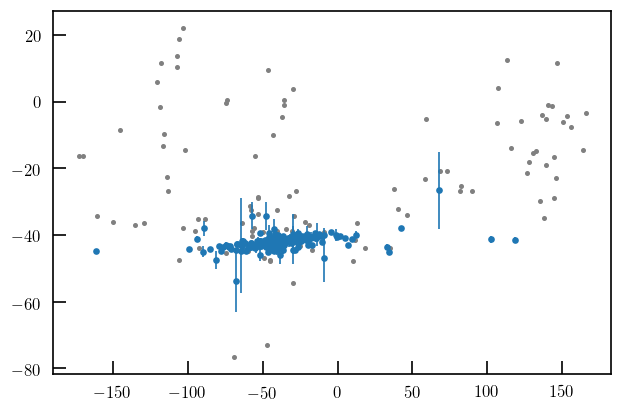

In [227]:
plt.figure(dpi=120)
plt.scatter(out_full["gx"], out_full["gvx"], s=4, c="0.5")
plt.scatter(out_full["gx"][mem], out_full["gvx"][mem], s=9)
plt.errorbar(
    out_full["gx"][mem],
    out_full["gvx"][mem],
    out_full["radial_velocity_error"][mem],
    ls="",
)

## checking RUWE

In [153]:
from wsdb import wsdb

# wsdb.upload_df(out_full[["source_id"]], "hyfull")

ruwe = wsdb.query(
    """select ruwe.source_id, ruwe
from semyeong_oh.hyfull as d left join gaia_dr2.ruwe on d.source_id=gaia_dr2.ruwe.source_id;"""
)

out_full_ruwe = out_full.merge(ruwe, on="source_id")

In [ ]:
out_full.columns

In [169]:
bad_astrometry = (out_full_ruwe['ruwe']>1.4)# | (out_full_ruwe['duplicated_source'])
print(bad_astrometry.sum())

127


In [162]:
out_full_ruwe.groupby(
    by=[out_full_ruwe["ruwe"] > 1.4, out_full_ruwe["duplicated_source"]]
)["source_id"].count()

ruwe   duplicated_source
False  False                1114
       True                  148
True   False                 117
       True                   10
Name: source_id, dtype: int64

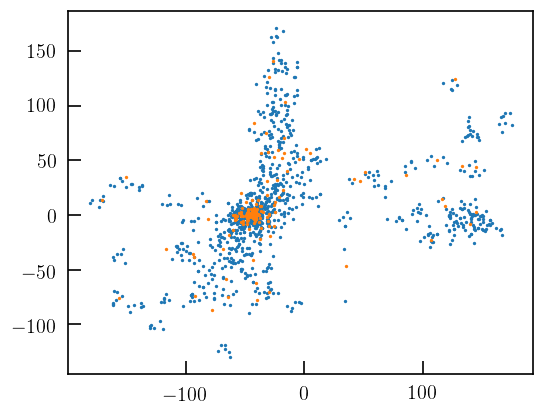

In [174]:
fig, ax = plt.subplots()
for l, g in out_full_ruwe.groupby('duplicated_source'):
    ax.scatter(g['gx'],g['gy'],s=1);

In [156]:
grp_by_pmem = out_full_ruwe.groupby(pd.cut(out_full_ruwe['mean_pmem_all'], [0., 0.5, 0.9, 1]))
grp_by_pmem[['duplicated_source']].describe()

duplicated_source                    
                          count unique    top  freq
mean_pmem_all                                      
(0.0, 0.5]                  199      2  False   183
(0.5, 0.9]                   42      2  False    40
(0.9, 1.0]                 1146      2  False  1006

In [414]:
out_full_ruwe["ruwe"].describe()

count    1389.000000
mean        1.235694
std         0.842037
min         0.725516
25%         1.008400
50%         1.089720
75%         1.203340
max        16.823600
Name: ruwe, dtype: float64

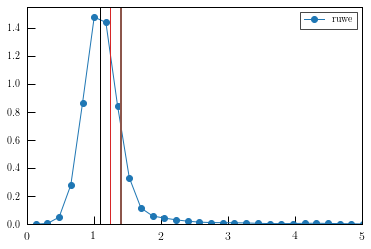

In [428]:
sns.kdeplot(out_full_ruwe["ruwe"], marker="o")
plt.xlim(0, 5)
plt.axvline(out_full_ruwe["ruwe"].median(), c="k")
plt.axvline(out_full_ruwe["ruwe"].mean(), c="C3")
plt.axvline(1.4, c="C5", lw=2);